In [1]:
import os
import torch
import json
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.optim as optim
import torch.nn as nn 
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from matplotlib import pyplot as plt 
import torchvision

from torchvision import transforms 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data.sampler import SequentialSampler

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_path = []
TRAIN_IMG_DIR = '/kaggle/input/licenseplate/train/images'
for root, dirs, files in os.walk(TRAIN_IMG_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        image_path.append(path)
len(image_path)

6218

In [3]:
label_path = []
TRAIN_LABEL_DIR = '/kaggle/input/licenseplate/train/labels'
for root, dirs, files in os.walk(TRAIN_LABEL_DIR):
    for file in files:
        # create path
        path = os.path.join(root,file)
        # add path to list
        label_path.append(path)
len(label_path)

6218

In [4]:
VALID_LABEL_DIR = '/kaggle/input/licenseplate/valid/labels'
VALID_IMG_DIR = '/kaggle/input/licenseplate/valid/images'
TEST_LABEL_DIR = '/kaggle/input/licenseplate/test/labels'
TEST_IMG_DIR = '/kaggle/input/licenseplate/test/images'
WEIGHT = '/kaggle/input/fasterrcnn/fasterrcnn_resnet50_fpn_best.pth'

In [5]:
class LicensePlateFasterRCNNDataset(Dataset):
    def __init__(self, image_dir, label_dir, transforms=None, resize=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transforms = transforms
        self.images = os.listdir(image_dir)
        self.resize = resize
    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_filename = self.images[index]
        image_path = os.path.join(self.image_dir, image_filename)
        label_path = os.path.join(self.label_dir, image_filename.replace('.jpg', '.txt'))

        image = cv2.imread(image_path)  # Read in BGR format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Parse YOLO annotations
        boxes = []
        labels = []
        if self.resize:
            image = cv2.resize(image, self.resize)  # Resize the image
            # Adjust bounding box coordinates based on the resize factor
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x_center, y_center, width, height = [float(x) for x in line.strip().split()]
                x_min = (x_center - width / 2) * image.shape[1]
                y_min = (y_center - height / 2) * image.shape[0]
                x_max = (x_center + width / 2) * image.shape[1]
                y_max = (y_center + height / 2) * image.shape[0]
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_label) + 1)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # Convert boxes and labels to tensors
        
        labels = torch.tensor(labels, dtype=torch.int64)
        # In Faster R-CNN, all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        # Calculate area of bounding boxes
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([index]),
            "area": areas,
            "iscrowd": iscrowd
        }

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=target["boxes"], labels=target["labels"])
            image = transformed['image']
            target["boxes"] = torch.tensor(transformed['bboxes'])
            target["labels"] = torch.tensor(transformed['labels'])
        else:
            image = transforms.ToTensor()(image)
        return image, target, index

In [6]:
train_transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
                A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
                A.GaussianBlur(blur_limit=(3, 7), p=0.2),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))  # Ensure bounding boxes are transformed
val_transform = A.Compose([
                    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                    ToTensorV2()
                    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
                )

In [7]:
train_dataset = LicensePlateFasterRCNNDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, transforms = train_transform, resize=(640,640))
valid_dataset = LicensePlateFasterRCNNDataset(VALID_IMG_DIR, VALID_LABEL_DIR, transforms = val_transform, resize=(640,640))
test_dataset = LicensePlateFasterRCNNDataset(TEST_IMG_DIR, TEST_LABEL_DIR, transforms = val_transform, resize=(640,640))

[[287 223 440 352]]
(640, 640, 3)
<class 'numpy.ndarray'>


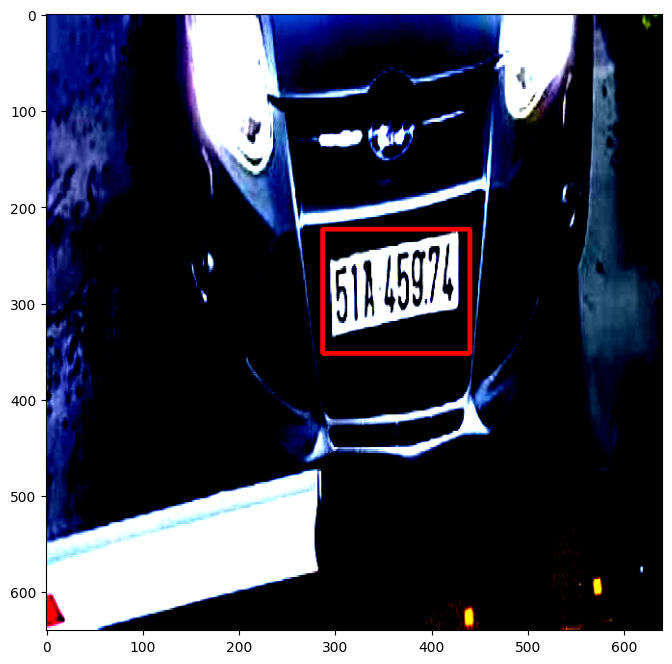

In [8]:
image, target, image_id = train_dataset[0]
# print(image, target)
boxes = target['boxes'].cpu().numpy().astype(np.int32)
print(boxes)
sample = image.permute(1,2,0).cpu().numpy()
print(sample.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print(type(sample))
for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.imshow(sample)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [10]:
class Averager:      ##Return the average loss 
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [12]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

num_classes = 3 # 2 class (license_plate, lights) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 237MB/s] 


In [13]:
# !pip install wandb
# !wandb login 'af3fff39f107c47a5441bad9ba81d9c46a34914b'

In [14]:
# import wandb
# wandb.init(
#     project = 'FasterRCNN',
#     name = 'augmented_pretrained',
#     config = {
#         'architecture': 'Faster RCNN',
#         'dataset': 'LicencePlate',
#         'epoch': 30
#     }
# )

In [15]:
# model.to(device)
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.00001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

# num_epochs = 5
# best_val_loss = float('inf')
# loss_hist = Averager()

# for epoch in range(num_epochs):
#     loss_hist.reset()
#     model.train()
#     for images, targets, image_ids in train_data_loader:
        
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)  ##Return the loss
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()
        
#         loss_hist.send(loss_value)  #Average out the loss

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()
        
#     train_loss = loss_hist.value

# #     model.eval()  # Set the model to evaluation mode
#     val_loss_hist = Averager()
#     with torch.no_grad():  # No need to track gradients during validation
#         for images, targets, image_ids in valid_data_loader:
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#             loss_dict = model(images, targets)  # Compute loss
#             losses = sum(loss for loss in loss_dict.values())
#             val_loss_hist.send(losses.item())

#     # Print and compare validation loss
#     val_loss = val_loss_hist.value
#     print(f"Epoch #{epoch} loss: {loss_hist.value}, Validation loss: {val_loss}")

#     # Save the model if validation loss is lower
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model_checkpoint.pth')
#         print(f"Model saved at Epoch #{epoch} with Validation loss: {val_loss}")

#     # Update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()
# #     wandb.log({'Val_loss': val_loss,
# #                'Train_loss': train_loss
# #               })
#     print(f"Epoch #{epoch} loss: {loss_hist.value}")

In [23]:
checkpoint = torch.load('/kaggle/input/checkpoint1/Faster_Aug_Pretr.pth')
model.load_state_dict(checkpoint)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [17]:
# images, targets, images_id = next(iter(test_data_loader))
# model.eval()
# sample = images[1].unsqueeze(0).to(device)
# output = model(sample)
# print(output)
# boxes = output[0]['boxes'].data.cpu().numpy()
# scores = output[0]['scores'].data.cpu().numpy()

# boxes = boxes[scores >= detection_threshold].astype(np.int32)

In [18]:
# fig, ax = plt.subplots(1, 1, figsize=(16, 8))
# # print(sample.shape)
# sample = sample.squeeze(0).permute(1,2,0).cpu().numpy()
# print(type(sample))
# plt.imshow(sample)
# for box in boxes:
#     cv2.rectangle(sample,
#                   (box[0], box[1]),
#                   (box[2], box[3]),
#                   (220, 0, 0), 2)
    
# ax.set_axis_off()
# ax.imshow(sample)

In [24]:
detection_threshold = 0.5

In [25]:
results = []
# Run inference
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
    for images, targets, image_ids in test_data_loader:
        images = list(image.to(device) for image in images)
        outputs = model(images)
        for i, output in enumerate(outputs):
            # Retrieve the scores and convert to numpy
            scores = output['scores'].data.cpu().numpy()
            class_ids = output['labels']
            # Retrieve the boxes and convert to numpy
            boxes = output['boxes'].data.cpu().numpy()
            
            # Apply the detection threshold
            valid_indices = scores >= detection_threshold
            scores = scores[valid_indices]
            class_ids = class_ids[valid_indices]
            boxes = boxes[valid_indices]
            
            # Convert boxes from [x_min, y_min, x_max, y_max] to [x_min, y_min, width, height]
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            
            # Collect results in COCO format
            for class_id, box, score in zip(class_ids, boxes, scores):
                result = {
                    "image_id": image_ids[i],
                    "category_id": class_id.item(),
                    "bbox": box.tolist(),  # Convert numpy array to list
                    "score": float(score),  # Convert numpy float to Python float
                    "file_name": image_ids[i]
                }
                results.append(result)


In [26]:
# Write results to a JSON file
with open('predictions.json', 'w') as f:
    json.dump(results, f)

In [27]:

# Replace these with the actual paths and values
gt_dir = '/kaggle/input/licenseplate/test/labels'
image_dir = '/kaggle/input/licenseplate/test/images'
output_json_path = 'ground_truths.json'

# Initialize the JSON structure
coco_format = {
    'images': [],
    'annotations': [],
    'categories': []
}

category_id_mapping = {'license plate': 2, 'lights': 1}  
# Add categories to COCO JSON
for category_name, category_id in category_id_mapping.items():
    coco_format['categories'].append({
        'id': category_id,
        'name': category_name,
        'supercategory': category_name
    })

# Populate images and annotations
annotation_id = 1

# Iterate over the dataset using the DataLoader
for image, targets, image_id in test_dataset:
    # Add image information
    coco_format['images'].append({
        'id': image_id,
        'file_name' : image_id,
        'width': image.shape[2],  # Assuming the image tensor is CxHxW
        'height': image.shape[1]
    })
    
    #lstargets['boxes']: Add annotations
    # Add annotation information
    for box, label in zip(targets['boxes'], targets['labels']):
        # Calculate box width and height
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        # Add annotation information
        coco_format['annotations'].append({
            'id': annotation_id,
            'image_id': image_id,
            'category_id': label.item(),
            'bbox': [x_min.item(), y_min.item(), width.item(), height.item()],
            'area': width.item() * height.item(),
            'iscrowd': 0  # or target['iscrowd'] if provided
        })
        annotation_id += 1
# Write the COCO format JSON to a file
with open(output_json_path, 'w') as f:
    json.dump(coco_format, f, indent=2)

In [28]:
print(len(coco_format['images']))
print(len(results))

887
934


In [29]:
!pip install pycocotools

In [30]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Initialize COCO ground truth API
coco_gt = COCO('/kaggle/working/ground_truths.json')  # path to the JSON with ground truth annotations

# Initialize COCO predictions API
coco_dt = coco_gt.loadRes('/kaggle/working/predictions.json')  # path to the JSON with detection results

# Initialize COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')

# Evaluate on a subset of images by setting their ids
# If you want to evaluate on the entire validation set, you can omit this line

# Run evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.58s).
Accumulating evaluation results...
DONE (t=0.11s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.561
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.913
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.625
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.718
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.439
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

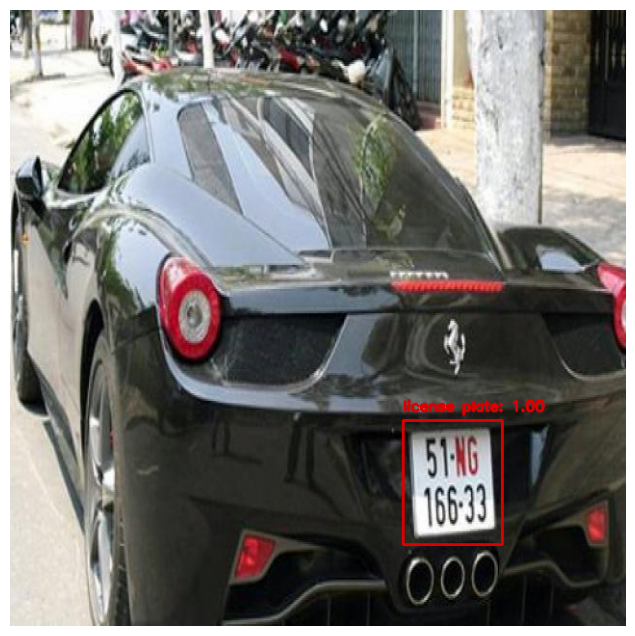

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_predictions(model, dataset, detection_threshold=0.5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    class_labels = {
        1: 'light',
        2: 'license plate'
    }
    idx = torch.randint(0, len(dataset), (1,)).item()
    image, target, image_id = dataset[idx]
    model.eval()  # Set the model to evaluation mode
    sample = image.to(device)
    with torch.no_grad():  # No need to track gradients
        output = model(sample.unsqueeze(0))
    # Convert detections to numpy arrays
    boxes = output[0]['boxes'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    labels = output[0]['labels']
    # Filter out detections below the threshold
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    
    # Convert the image from tensor to numpy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    sample = sample.squeeze(0).permute(1, 2, 0).cpu().numpy()
    sample = sample * std + mean  # Reverse the normalization
    sample = (sample * 255.0).astype(np.uint8)
    sample = sample.astype(np.uint8)
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    
    # Draw the boxes on the image
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (220, 0, 0), 2)
        class_name = class_labels[label.item()]
        label_str = f'{class_name}: {score:.2f}'
        cv2.putText(sample, label_str, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (220,0,0), 2)
    # Show the image with bounding boxes
    ax.imshow(sample)
    ax.axis('off')  # Disable axis
    plt.show()

visualize_predictions(model, test_dataset)

In [32]:
import os

def save_predictions(model, dataloader, save_dir, detection_threshold=0.5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    class_labels = {
        1: 'light',
        2: 'license plate'
    }

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    model.eval()  # Set the model to evaluation mode

    for i, (images, targets, image_ids) in enumerate(dataloader):
        sample = list(image.to(device) for image in images)

        with torch.no_grad():  # No need to track gradients
            output = model(sample)
        for j in range(len(images)):
            boxes = output[j]['boxes'].data.cpu().numpy()
            scores = output[j]['scores'].data.cpu().numpy()
            labels = output[j]['labels']
            boxes = boxes[scores >= detection_threshold].astype(np.int32)
            image = images[j].permute(1, 2, 0).cpu().numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = image * std + mean  # Reverse the normalization
            image = (image * 255.0).astype(np.uint8)
            for k, box in enumerate(boxes):
                cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 0, 220), 2)
                score = scores[k]
                label = labels[k].item()  
                class_name = class_labels[label]
                label_str = f'{class_name}: {score:.2f}'
                cv2.putText(image, label_str, (box[0], box[1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,220), 2)

            save_path = os.path.join(save_dir, f'predicted_image_{i}_{j}.jpg')
            cv2.imwrite(save_path, image)

# Sử dụng hàm mới
save_predictions(model, test_data_loader, 'prediction_image')


In [33]:
import shutil

shutil.make_archive('/kaggle/working/predictions', 'zip', '/kaggle/working/prediction_image')

'/kaggle/working/predictions.zip'